# Challenge 8: Decision Tree Challenges

| Title        | Answer                     |
| :---------- | :------------------------ |
| Topic:       | Decision Tree Challenges | 
| Date:        | 2016/08/06                 |
| Name:        | Michelle L. Gill           |
| Worked with: | None                       | 




In [65]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

import pydotplus
from IPython.display import Image

## Question 1

For the house representatives data set, fit and evaluate a decision tree classifier. Examine the rules your tree uses.

In [66]:
vote_cols = ['v1', 'v2', 'v3', 'v4', 'v5',
             'v6', 'v7', 'v8', 'v9', 'v10',
             'v11', 'v12', 'v13', 'v14', 'v15', 'v16']

house = pd.read_csv('../../../challenges_data/house-votes-84.data',
                    names=vote_cols + ['party'],
                    index_col=None)

house['party'] = house.party.str.strip().str.replace('.', '')
house = house.replace('y', 1).replace('n', 0).replace('?', np.NaN)

# house[feat_cols] = house[feat_cols].fillna(house[feat_cols].mean())

# Fill with Bernoulli probability distribution
vote_totals = (pd.Series(house[vote_cols].values.ravel())
               .dropna()
               .astype(int)
               .value_counts()
               )

vote_totals /= vote_totals.sum()
p_yes = vote_totals.loc[1]

def vote_filler(df_col, p_yes=p_yes):
    mask = df_col.isnull()
    fill_size = mask.sum()
    df_col.loc[mask] = np.random.binomial(1, p=p_yes, size=fill_size)
    return df_col

house[vote_cols] = house[vote_cols].apply(vote_filler, axis=0).astype(int)

house.head(5)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,party
0,0,1,0,1,1,1,0,0,0,1,1,1,1,1,0,1,republican
1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,republican
2,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,democrat
3,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1,democrat
4,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1,democrat


In [67]:
train, test = train_test_split(house, test_size=0.3, random_state=4444)

In [68]:
model = DecisionTreeClassifier(max_depth=3)
model = model.fit(train[vote_cols], train['party'])

In [69]:
# Function to convert model to image
# This makes use of Ghostscript and ImageMagick because my dot
# program does not seem to be able to make PNG files

def convert_to_image(model, out_dotfile):
    out_base = os.path.splitext(out_dotfile)[1]
    
    export_graphviz(model, out_file=out_dotfile)
    
    ps_file = out_base + '.ps'
    pdf_file = out_base + '.pdf'
    png_file = out_base + '.png'

    !dot -Tps {out_dotfile} -o {ps_file} >> /dev/null

    # Get the sizes from ImageMagick
    size = ! identify {ps_file} | cut -d' ' -f3 | sed 's/x/ /g'
    size1, size2 = [int(x) for x in size[0].split(' ')]

    # Convert to PDF with Ghostscript
    size_str = "\"<< /PageSize [{} {}] >> setpagedevice\"".format(size1+200, size2+200)
    !gs -sOutputFile={pdf_file} -sDEVICE=pdfwrite  -c {size_str} -dBATCH -dNOPAUSE {ps_file} >> /dev/null

    # Convert PDF to PNG and crop with ImageMagick
    !convert -trim {pdf_file} {png_file} >> /dev/null

    !rm {out_dotfile} {ps_file} {pdf_file}
    
    return png_file

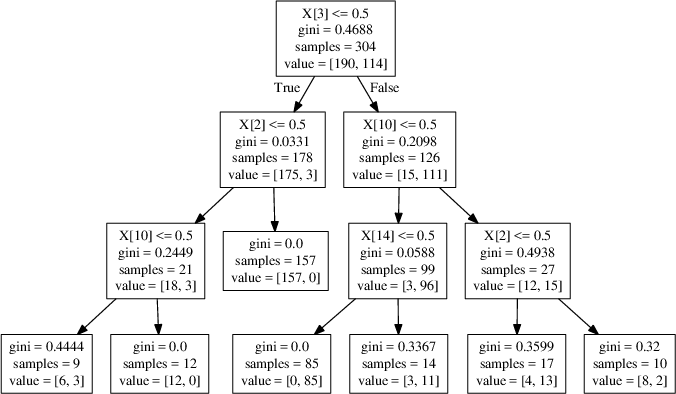

In [70]:
Image(convert_to_image(model, 'tree_votes.dot'))

In [79]:
vote_cols[3]

'v4'

Primary decision is on vote `v4`.

## Question 2
Fit and evaluate a decision tree classifier for your movie dataset. Examine the rules your tree uses.

In [75]:
movies = pd.read_csv('../../../challenges_data/2013_movies.csv')

# fill missing data
movies = movies.fillna(movies.median())

# Convert ratings to integers
movies = movies.loc[movies.Rating!='G']
conv_dict = {'PG':0, 'PG-13':1, 'R':2}
movies['Rating'] = movies.Rating.apply(lambda x: conv_dict[x])

feat_cols = ['Budget', 'DomesticTotalGross', 'Runtime']
mtrain, mtest = train_test_split(movies, test_size=0.3, random_state=4444)

In [77]:
model = DecisionTreeClassifier(max_depth=3)
model = model.fit(mtrain[feat_cols], mtrain['Rating'])

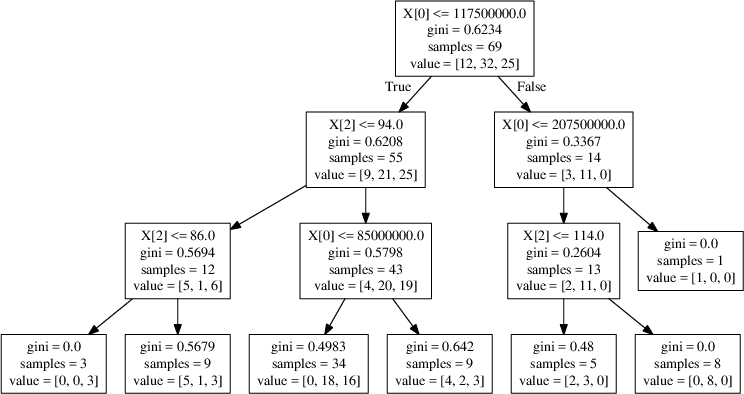

In [78]:
Image(convert_to_image(model, 'tree_movies.dot'))

Primary decision is on `Budget` is less than or equal to $117,500,000.

## Question 3
Tackle the Titanic Survivors kaggle competition with decision trees. Look at your splits; how does your tree decide?

In [101]:
ttrain = pd.read_csv('titanic_train.csv')
#ttest = pd.read_csv('titanic_test.csv')

ttrain = ttrain.fillna(ttrain.median())

In [102]:
ttrain.head(1)

,﻿PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [103]:
feat_cols = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch',  'Age', 'Fare']
label_cols = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']
pred_col = 'Survived'

In [108]:
for col in label_cols:
    lb = LabelEncoder().fit(ttrain[col])
    ttrain[col] = lb.transform(ttrain[col])

/Volumes/Files/miniconda/envs/scienv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/Volumes/Files/miniconda/envs/scienv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [109]:
model = DecisionTreeClassifier(max_depth=3)
model = model.fit(ttrain[feat_cols], ttrain[pred_col])

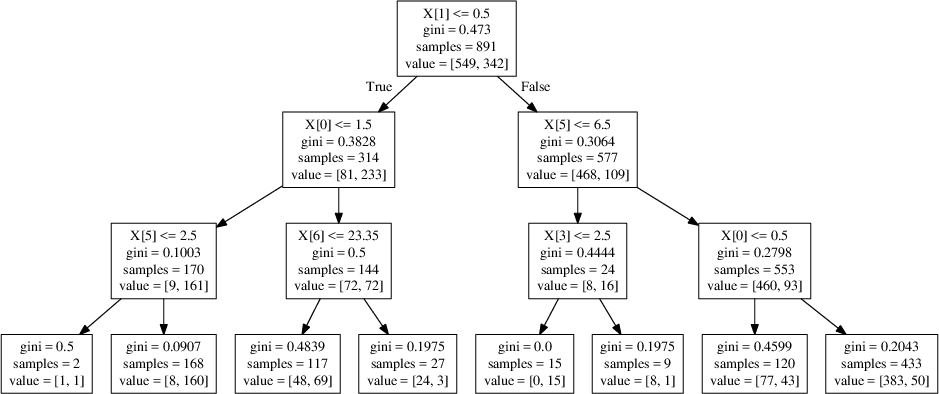

In [110]:
Image(convert_to_image(model, 'tree_titanic.dot'))

The primary node divides on `Sex`. Secondary nodes are `Pclass` (passenger class) and `Age`.